Initial rows: 72946
Handling duplicates and reindexing...
Inferred freq: None Rows after handling duplicates: 72946
Standardizing columns and imputing prices...
Rows after standardizing and imputing: 72946
Optional: removing extreme outliers...
Rows after removing outliers: 72946
Feature engineering...
Rows after feature engineering: 72946
Creating lags and target...
Rows after creating lags and target: 72944
Model rows available: 72944
Training models...
Validation metrics
RandomForest: {'rmse': np.float64(1.7188101640425548), 'mae': 1.4557732095651565, 'r2': -0.5595170400756315}
GradientBoosting: {'rmse': np.float64(1.5951461708311265), 'mae': 1.3730170096313725, 'r2': -0.34318325648336745}
Test metrics for chosen model (GradientBoosting): {'rmse': np.float64(1.1232322480838446), 'mae': 0.9437547150281833, 'r2': 0.038926909890689476}
Saved model to: /mnt/data/best_vol_model.pkl
Saved scaler to: /mnt/data/feature_scaler.pkl


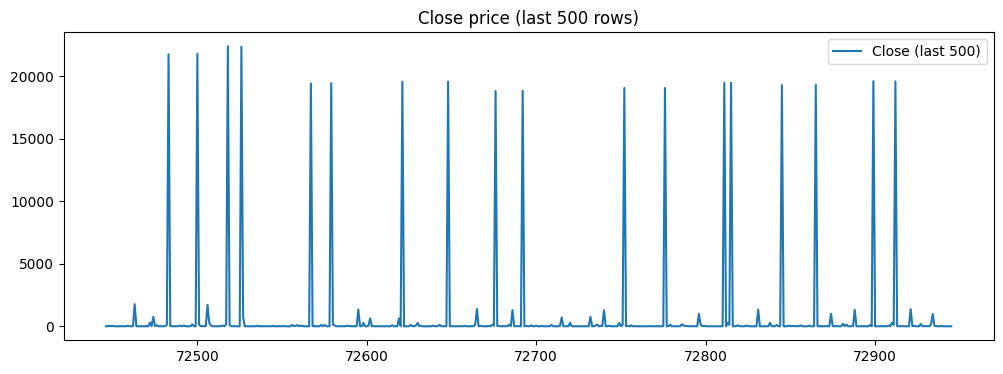

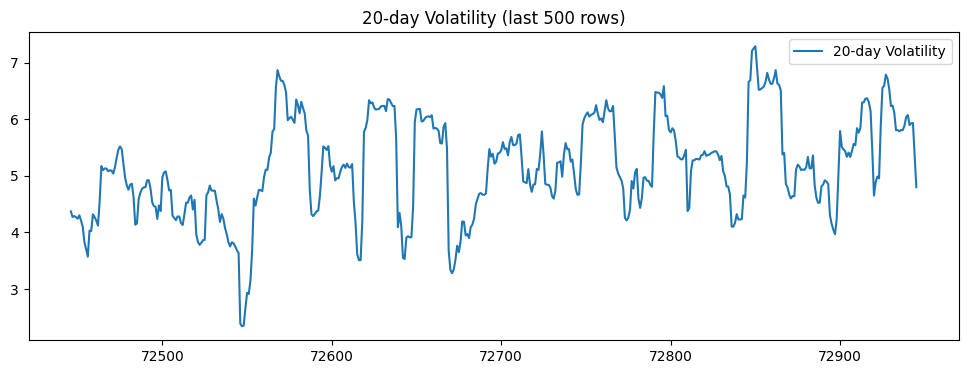

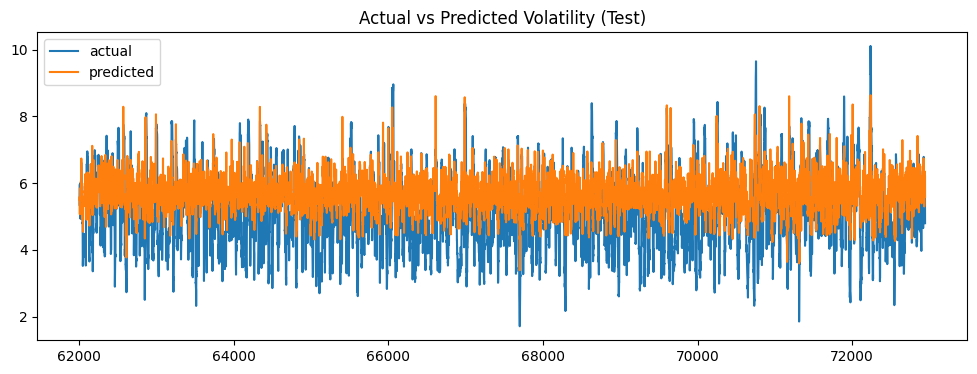

Saved cleaned+feature dataset to: /mnt/data/dataset_cleaned.csv
Finished pipeline. Summary:
{'model_name': 'GradientBoosting', 'val_metrics': {'rf': {'rmse': np.float64(1.7188101640425548), 'mae': 1.4557732095651565, 'r2': -0.5595170400756315}, 'gb': {'rmse': np.float64(1.5951461708311265), 'mae': 1.3730170096313725, 'r2': -0.34318325648336745}}, 'test_metrics': {'rmse': np.float64(1.1232322480838446), 'mae': 0.9437547150281833, 'r2': 0.038926909890689476}, 'model_file': '/mnt/data/best_vol_model.pkl', 'scaler_file': '/mnt/data/feature_scaler.pkl', 'cleaned_file': '/mnt/data/dataset_cleaned.csv'}


In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

INPUT_PATH = "/content/dataset.csv"
CLEANED_PATH = "/mnt/data/dataset_cleaned.csv"
MODEL_OUT = "/mnt/data/best_vol_model.pkl"
SCALER_OUT = "/mnt/data/feature_scaler.pkl"

# Parameters
VOL_WINDOW = 20
TARGET_HORIZON = 1
TEST_RATIO = 0.15
VAL_RATIO = 0.15
RANDOM_STATE = 42

def compute_rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=period, min_periods=1).mean()
    ma_down = down.rolling(window=period, min_periods=1).mean()
    rs = ma_up / (ma_down.replace(0, np.nan))
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(50)

def compute_atr(df, period=14):
    high_low = df['High'] - df['Low']
    high_close = (df['High'] - df['Close'].shift()).abs()
    low_close = (df['Low'] - df['Close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def load_and_prepare(path):
    df = pd.read_csv(path)
    date_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
    if len(date_cols) == 0:
        df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
        date_col = 'Date'
    else:
        date_col = date_cols[0]
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df[~df[date_col].isna()].copy()
    df = df[~(df.drop(columns=[date_col]).isna().all(axis=1))]
    df = df.drop_duplicates()
    df = df.sort_values(by=date_col).reset_index(drop=True)
    df.set_index(date_col, inplace=True)
    return df


def handle_duplicates_and_reindex(df):
    if df.index.duplicated().any():
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        non_numeric = [c for c in df.columns if c not in numeric_cols]
        agg_dict = {c: 'mean' for c in numeric_cols}
        agg_dict.update({c: 'first' for c in non_numeric})
        df = df.groupby(level=0).agg(agg_dict)


    try:
        inferred = pd.infer_freq(df.index[:min(len(df.index), 50)])
    except Exception:
        inferred = None

    df.index.name = 'Date'
    return df, inferred

def standardize_and_impute(df):
    col_map = {}
    cols = list(df.columns)
    for c in cols:
        lc = c.lower()
        if lc in ('open', 'open_price'):
            col_map[c] = 'Open'
        elif 'open' in lc and 'price' in lc:
            col_map[c] = 'Open'
        elif lc in ('high', 'high_price'):
            col_map[c] = 'High'
        elif lc in ('low', 'low_price'):
            col_map[c] = 'Low'
        elif lc in ('close', 'close_price', 'adjclose'):
            col_map[c] = 'Close'
        elif 'vol' in lc:
            col_map[c] = 'Volume'
        elif 'market' in lc and 'cap' in lc:
            col_map[c] = 'MarketCap'
        elif lc in ('symbol', 'crypto_name', 'name'):
            col_map[c] = 'Symbol'
        elif lc == 'date':
            pass
    df = df.rename(columns=col_map)

    for c in ['Open','High','Low','Close','Volume']:
        if c not in df.columns:
            df[c] = np.nan

    price_cols = ['Open','High','Low','Close']
    df[price_cols] = df[price_cols].ffill().bfill().interpolate(method='linear', limit_direction='both')

    df['Volume'] = df.get('Volume', pd.Series(index=df.index, dtype=float)).ffill().bfill().fillna(0)

    df[price_cols] = df[price_cols].replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=price_cols, how='any')

    df['Low'] = df[['Low','Open','Close','High']].min(axis=1)
    df['High'] = df[['Low','Open','Close','High']].max(axis=1)
    return df

def remove_price_outliers(df, window=20, z_thresh=7):
    rolling_med = df['Close'].rolling(window=window, min_periods=1).median()
    rolling_std = df['Close'].rolling(window=window, min_periods=1).std().fillna(0)
    z = (df['Close'] - rolling_med).abs() / (rolling_std.replace(0, np.nan))
    mask = z > z_thresh
    removed = mask.sum()
    if removed > 0:
        print(f"Removing {removed} outlier rows (z > {z_thresh})")
    df = df[~mask]
    return df

def feature_engineering(df, vol_window=VOL_WINDOW):
    df = df.copy()
    df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Volatility'] = df['LogRet'].rolling(window=vol_window, min_periods=max(2, vol_window//2)).std()

    df['SMA7'] = df['Close'].rolling(7, min_periods=1).mean()
    df['SMA14'] = df['Close'].rolling(14, min_periods=1).mean()
    df['EMA14'] = df['Close'].ewm(span=14, adjust=False).mean()

    df['RSI14'] = compute_rsi(df['Close'], period=14)
    df['ATR14'] = compute_atr(df, period=14)

    sma20 = df['Close'].rolling(20, min_periods=1).mean()
    std20 = df['Close'].rolling(20, min_periods=1).std().fillna(0)
    df['BB_upper'] = sma20 + 2 * std20
    df['BB_lower'] = sma20 - 2 * std20
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / (sma20.replace(0, np.nan))

    if 'MarketCap' in df.columns:
        df['Liquidity'] = df['Volume'] / (df['MarketCap'].replace(0, np.nan))
    else:
        df['Liquidity'] = df['Volume'] / (df['Volume'].rolling(20, min_periods=1).mean().replace(0, np.nan))

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df

def create_lags_and_target(df, lag_features=None, lags=[1], target_col='Volatility', horizon=TARGET_HORIZON):
    df = df.copy()
    if lag_features is None:
        lag_features = ['Close','Volume','SMA7','SMA14','EMA14','RSI14','ATR14','BB_width','Liquidity','LogRet']

    for feat in lag_features:
        for l in lags:
            df[f'{feat}_lag{l}'] = df[feat].shift(l)

    df['target'] = df[target_col].shift(-horizon)
    df = df.dropna(subset=[f'{feat}_lag{lags[-1]}' for feat in lag_features] + ['target'])
    return df, [f'{feat}_lag{lags[-1]}' for feat in lag_features]

def time_train_val_test_split(X, y, val_ratio=VAL_RATIO, test_ratio=TEST_RATIO):
    n = len(X)
    test_n = int(n * test_ratio)
    val_n = int(n * val_ratio)
    train_n = n - val_n - test_n
    X_train = X.iloc[:train_n]
    y_train = y.iloc[:train_n]
    X_val = X.iloc[train_n:train_n+val_n]
    y_val = y.iloc[train_n:train_n+val_n]
    X_test = X.iloc[train_n+val_n:]
    y_test = y.iloc[train_n+val_n:]
    return X_train, X_val, X_test, y_train, y_val, y_test

def evaluate_preds(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

def train_and_select_model(X_train, y_train, X_val, y_val):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
    gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=RANDOM_STATE)

    rf.fit(X_train_s, y_train)
    gb.fit(X_train_s, y_train)

    rf_val_preds = rf.predict(X_val_s)
    gb_val_preds = gb.predict(X_val_s)

    rf_metrics = evaluate_preds(y_val, rf_val_preds)
    gb_metrics = evaluate_preds(y_val, gb_val_preds)

    print("Validation metrics")
    print("RandomForest:", rf_metrics)
    print("GradientBoosting:", gb_metrics)

    if rf_metrics['rmse'] <= gb_metrics['rmse']:
        chosen = rf
        chosen_name = 'RandomForest'
    else:
        chosen = gb
        chosen_name = 'GradientBoosting'

    return chosen, chosen_name, scaler, {'rf': rf_metrics, 'gb': gb_metrics}

def run_pipeline(df):
    print(f"Initial rows: {len(df)}")

    print("Handling duplicates and reindexing...")
    df, freq = handle_duplicates_and_reindex(df)
    print("Inferred freq:", freq, "Rows after handling duplicates:", len(df))
    if df.empty:
        print("DataFrame is empty after handling duplicates. Exiting pipeline.")
        return None

    print("Standardizing columns and imputing prices...")
    df = standardize_and_impute(df)
    print("Rows after standardizing and imputing:", len(df))
    if df.empty:
        print("DataFrame is empty after standardizing and imputing. Exiting pipeline.")
        return None

    print("Optional: removing extreme outliers...")
    df = remove_price_outliers(df)
    print("Rows after removing outliers:", len(df))
    if df.empty:
        print("DataFrame is empty after removing outliers. Exiting pipeline.")
        return None


    print("Feature engineering...")
    df = feature_engineering(df)
    print("Rows after feature engineering:", len(df))
    if df.empty:
        print("DataFrame is empty after feature engineering. Exiting pipeline.")
        return None

    print("Creating lags and target...")
    df_model, feature_cols = create_lags_and_target(df)
    print("Rows after creating lags and target:", len(df_model))
    if df_model.empty:
        print("DataFrame is empty after creating lags and target. Exiting pipeline.")
        return None


    print("Model rows available:", len(df_model))
    X = df_model[feature_cols].fillna(0)
    y = df_model['target']

    X_train, X_val, X_test, y_train, y_val, y_test = time_train_val_test_split(X, y)

    if X_train.empty or X_val.empty or X_test.empty:
        print(f"One or more splits are empty. Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}. Cannot proceed with training. Exiting pipeline.")
        return None

    print("Training models...")
    model, model_name, scaler, val_metrics = train_and_select_model(X_train, y_train, X_val, y_val)
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])
    X_train_val_s = scaler.fit_transform(X_train_val)
    model.fit(X_train_val_s, y_train_val)

    X_test_s = scaler.transform(X_test)
    preds_test = model.predict(X_test_s)
    test_metrics = evaluate_preds(y_test, preds_test)
    print("Test metrics for chosen model ({}):".format(model_name), test_metrics)

    joblib.dump(model, MODEL_OUT)
    joblib.dump(scaler, SCALER_OUT)
    print("Saved model to:", MODEL_OUT)
    print("Saved scaler to:", SCALER_OUT)

    try:
        plt.figure(figsize=(12,4))
        plt.plot(df['Close'].iloc[-500:], label='Close (last 500)')
        plt.title("Close price (last 500 rows)")
        plt.legend()
        plt.show()


        plt.figure(figsize=(12,4))
        plt.plot(df['Volatility'].iloc[-500:], label=f'{VOL_WINDOW}-day Volatility')
        plt.title(f"{VOL_WINDOW}-day Volatility (last 500 rows)")
        plt.legend()
        plt.show()


        test_dates = df_model.iloc[-len(y_test):].index
        plt.figure(figsize=(12,4))
        plt.plot(test_dates, y_test.values, label='actual')
        plt.plot(test_dates, preds_test, label='predicted')
        plt.title('Actual vs Predicted Volatility (Test)')
        plt.legend()
        plt.show()
    except Exception as e:
        print("Plotting failed:", e)


    df.reset_index(inplace=True)
    df.to_csv(CLEANED_PATH, index=False)
    print("Saved cleaned+feature dataset to:", CLEANED_PATH)


    return {
        'model_name': model_name,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'model_file': MODEL_OUT,
        'scaler_file': SCALER_OUT,
        'cleaned_file': CLEANED_PATH
    }



if __name__ == "__main__":
    os.makedirs("/mnt/data", exist_ok=True)
    summary = run_pipeline(df)
    print("Finished pipeline. Summary:")
    print(summary)